In [12]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import os

In [13]:
df = pd.read_csv('../data/iter_pmass_err_v4.csv')

In [14]:
df.loc[df['run_id'] > 10, 'run_id'] = df.loc[df['run_id'] > 10, 'run_id'] - 10

In [15]:
df['pct_abs_err'] = df['total_abs_err'] / df['num_choosers']

In [16]:
num_metrics = 5
non_metric_cols = ['num_alts', 'num_choosers', 'sample_rate','run_id']
metric_cols = ['total_abs_err', 'pct_abs_err', 'rmse', 'mape', 'sd_pct_err']
metrics = np.split(np.array(metric_cols), num_metrics)
metric_labels = [
    "Total Absolute Error",
    "Pct Abs Err",
    "RMSE",
    "MAPE",
    "Std. Dev. Pct. Err.",
]

In [17]:
# standardized errs
maxs = np.abs(df[df['sample_rate'] == df['sample_rate'].min()]).groupby(['run_id', 'num_alts'])[['total_abs_err','pct_abs_err', 'rmse','mape','sd_pct_err']].mean()
maxs = maxs.reset_index().rename(columns={col: col + '_max_n_alts' for col in maxs.columns})
df = pd.merge(df.abs(), maxs, on=['run_id', 'num_alts'])
for col in metric_cols:
    df[col + '_std_n_alts'] = df[col] / df[col + '_max_n_alts']
    
# standardized errs
maxs = np.abs(df[df['num_alts'] == df['num_alts'].min()]).groupby(['run_id', 'sample_rate'])[['total_abs_err','pct_abs_err', 'rmse','mape','sd_pct_err']].mean()
maxs = maxs.reset_index().rename(columns={col: col + '_max_rate' for col in maxs.columns})
df = pd.merge(df.abs(), maxs, on=['run_id', 'sample_rate'])
for col in metric_cols:
    df[col + '_std_rate'] = df[col] / df[col + '_max_rate']

/home/mgardner/anaconda3/envs/proba/lib/python3.9/site-packages/numpy/lib/function_base.py:4009: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


Text(0.5, 0.98, 'Dispersion Error')

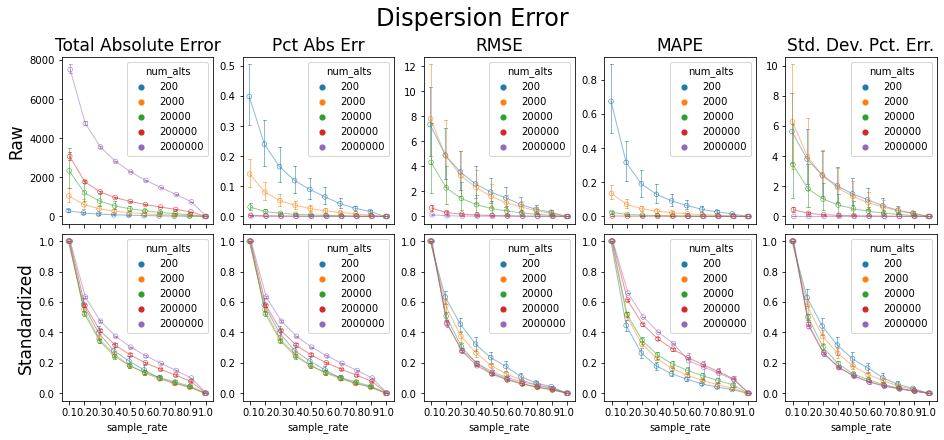

In [18]:
fig, axarr = plt.subplots(2, num_metrics, figsize=(13, 6), sharex=True, constrained_layout=True)

for col, metric in enumerate(metric_cols):
    
    g = sns.pointplot(
        data=df,
        x='sample_rate', y=metric,
        hue='num_alts', dodge=True, scale=0.7, ax=axarr[0, col], capsize=.2)

    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

    axarr[0, col].set_title(metric_labels[col], fontsize=17)

    axarr[0, col].set_ylabel("")
    axarr[0, col].set_xlabel("")
    
    g = sns.pointplot(
        data=df,
        x='sample_rate', y=metric + '_std_n_alts',
        hue='num_alts', dodge=True, scale=0.7, ax=axarr[1, col], capsize=.2)

    plt.setp(g.collections, alpha=1, facecolor='none', lw=.5)  # for the markers
    plt.setp(g.lines, alpha=.5, lw=1)                          # for the lines

    axarr[1, col].set_ylabel("")
    
axarr[0, 0].set_ylabel("Raw", fontsize=17)
axarr[1, 0].set_ylabel("Standardized", fontsize=17)

fig.suptitle("Dispersion Error", fontsize=24)

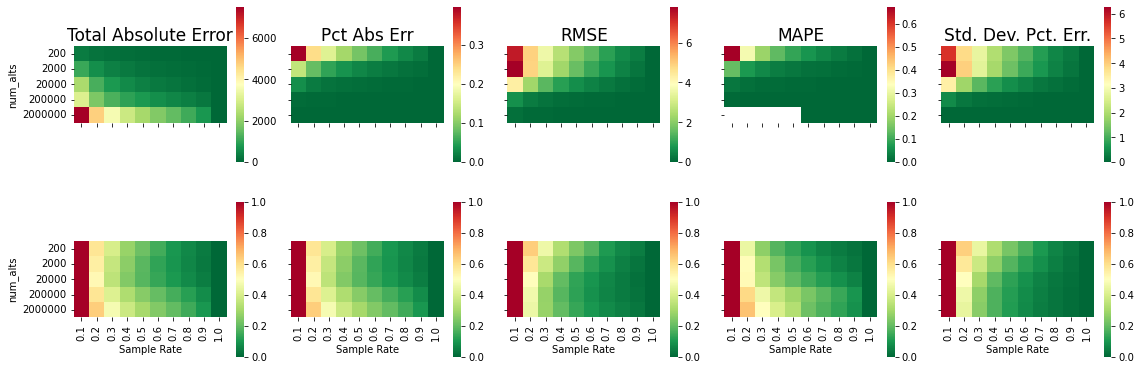

In [19]:
fig, axarr = plt.subplots(2, num_metrics, figsize=(16, 6), sharex=True, sharey=True,)

for col, metric in enumerate(metric_cols):
    
    g = sns.heatmap(
        df[['sample_rate', 'num_alts', metric]].pivot_table(
            index='num_alts',columns='sample_rate',values=metric), ax=axarr[0, col], square=True,
        cbar_kws={"shrink": .72}, cmap='RdYlGn_r')

    axarr[0, col].set_title(metric_labels[col], fontsize=17)
    axarr[0, col].set_ylabel("")
    axarr[0, col].set_xlabel("")
    
    g = sns.heatmap(
        df[['sample_rate','num_alts', metric + '_std_n_alts']].pivot_table(
            index='num_alts',columns='sample_rate',values=metric + '_std_n_alts'), ax=axarr[1, col],
        vmin=0, vmax=1, square=True, cbar_kws={"shrink": .72}, cmap='RdYlGn_r')
    
    axarr[1, col].set_ylabel("")
    axarr[1, col].set_xlabel("Sample Rate")

_ = axarr[1, 0].set_ylabel("num_alts")
_ = axarr[0, 0].set_ylabel("num_alts")
_ = axarr[0, 0].set_yticklabels(axarr[0, 0].get_yticklabels(), rotation='horizontal')
_ = axarr[1, 0].set_yticklabels(axarr[0, 0].get_yticklabels(), rotation='horizontal')
fig.tight_layout()